## Adding a degree of urbanization to points

In [13]:
# Import required libraries
import pandas as pd

## Loading the dataset
companies = pd.read_csv('geocoding_results/geocoded_companies.csv')

# Drop the specified columns
columns_to_drop = ['formatted_address', 'address_cleaned']
companies = companies.drop(columns=[col for col in columns_to_drop if col in companies.columns])

# Drop rows where either 'latitude' or 'longitude' is missing
#companies = companies.dropna(subset=['latitude', 'longitude'])

### Adding Provinces, Districts and Wards

Checking for shapefiles...
Available files: ['license.txt', 'ZWE_adm0.cpg', 'ZWE_adm0.csv', 'ZWE_adm0.dbf', 'ZWE_adm0.prj', 'ZWE_adm0.shp', 'ZWE_adm0.shx', 'ZWE_adm1.cpg', 'ZWE_adm1.csv', 'ZWE_adm1.dbf', 'ZWE_adm1.prj', 'ZWE_adm1.shp', 'ZWE_adm1.shx', 'ZWE_adm2.cpg', 'ZWE_adm2.csv', 'ZWE_adm2.dbf', 'ZWE_adm2.prj', 'ZWE_adm2.shp', 'ZWE_adm2.shx', 'ZWE_adm3.shp', 'zwe_admbnda_adm3_zimstat_ocha_20180911.cpg', 'zwe_admbnda_adm3_zimstat_ocha_20180911.dbf', 'zwe_admbnda_adm3_zimstat_ocha_20180911.prj', 'zwe_admbnda_adm3_zimstat_ocha_20180911.shp', 'zwe_admbnda_adm3_zimstat_ocha_20180911.shp.xml', 'zwe_admbnda_adm3_zimstat_ocha_20180911.shx']
Successfully loaded country data from ZWE_adm0.shp
Successfully loaded province data from ZWE_adm1.shp
Successfully loaded district data from ZWE_adm2.shp
Error loading ZWE_adm3.shp: Unable to open ZWE_adm\ZWE_adm3.shx or ZWE_adm\ZWE_adm3.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.
Preparing company data...
Adding administrat

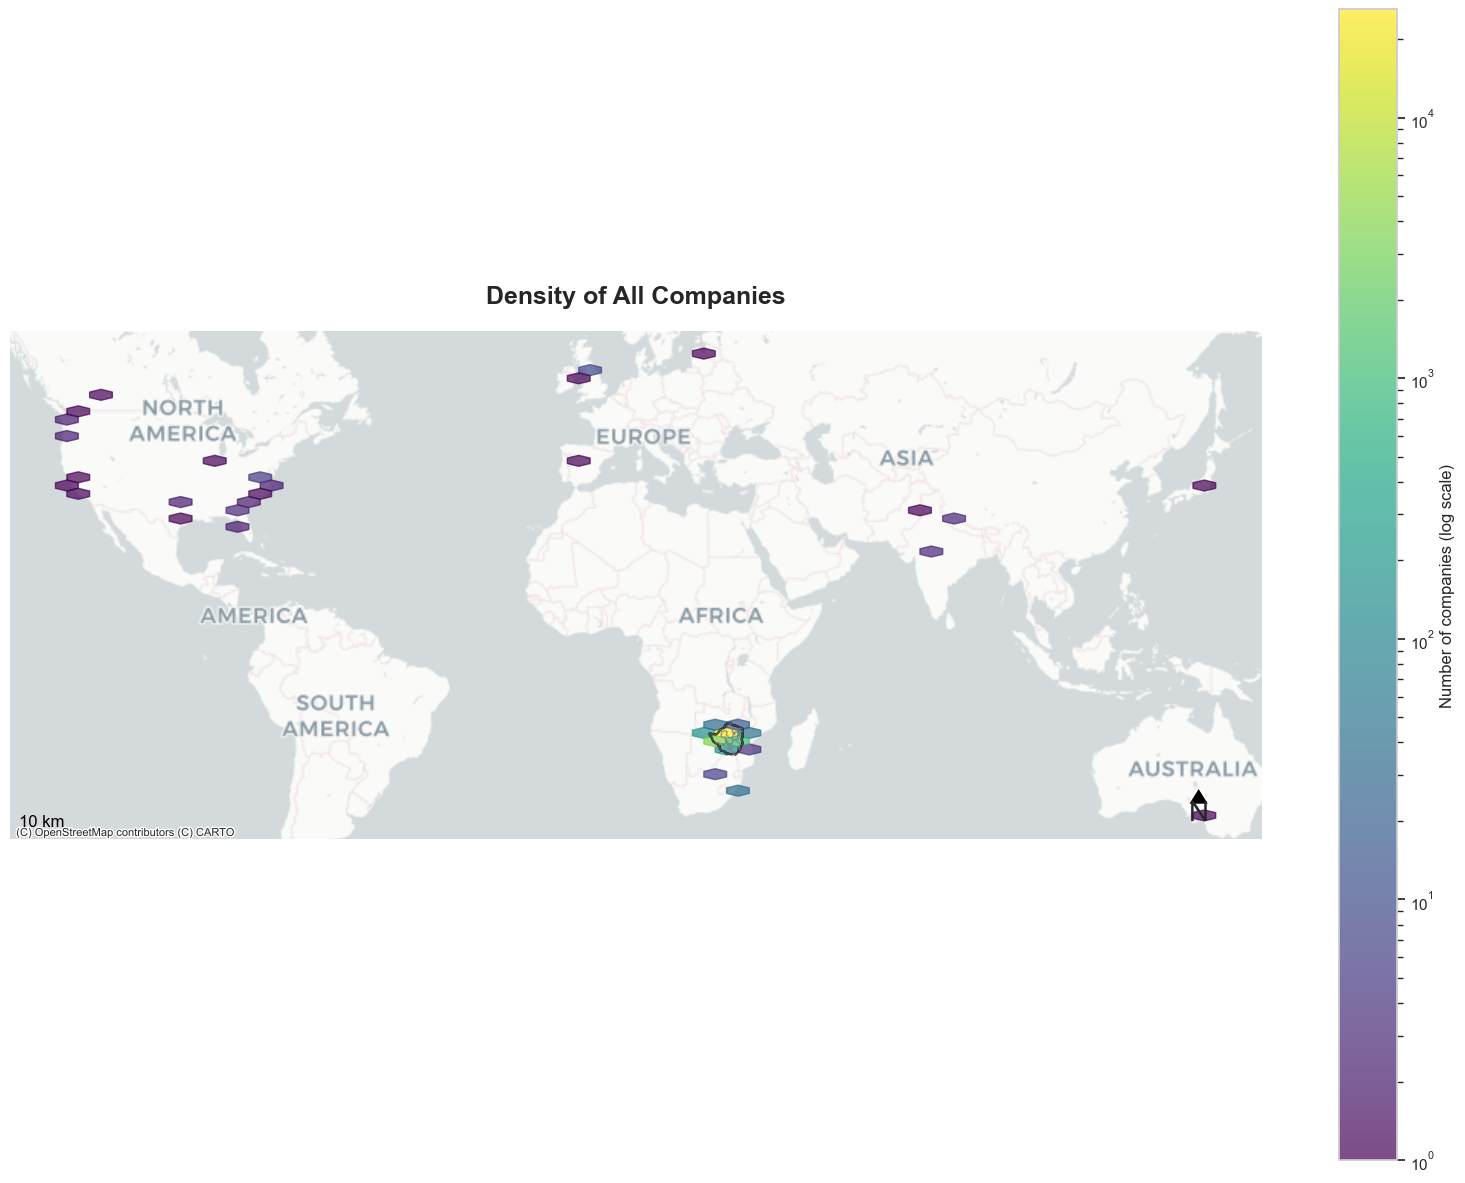

C:\Users\perkins.watambwa\AppData\Local\Temp\ipykernel_37768\1473138497.py:65: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  country_boundary = country_shape.geometry.unary_union


Found 31177 companies within country boundaries.

Creating map with companies in Zimbabwe...
Map saved as zimbabwe_companies_density_map.png


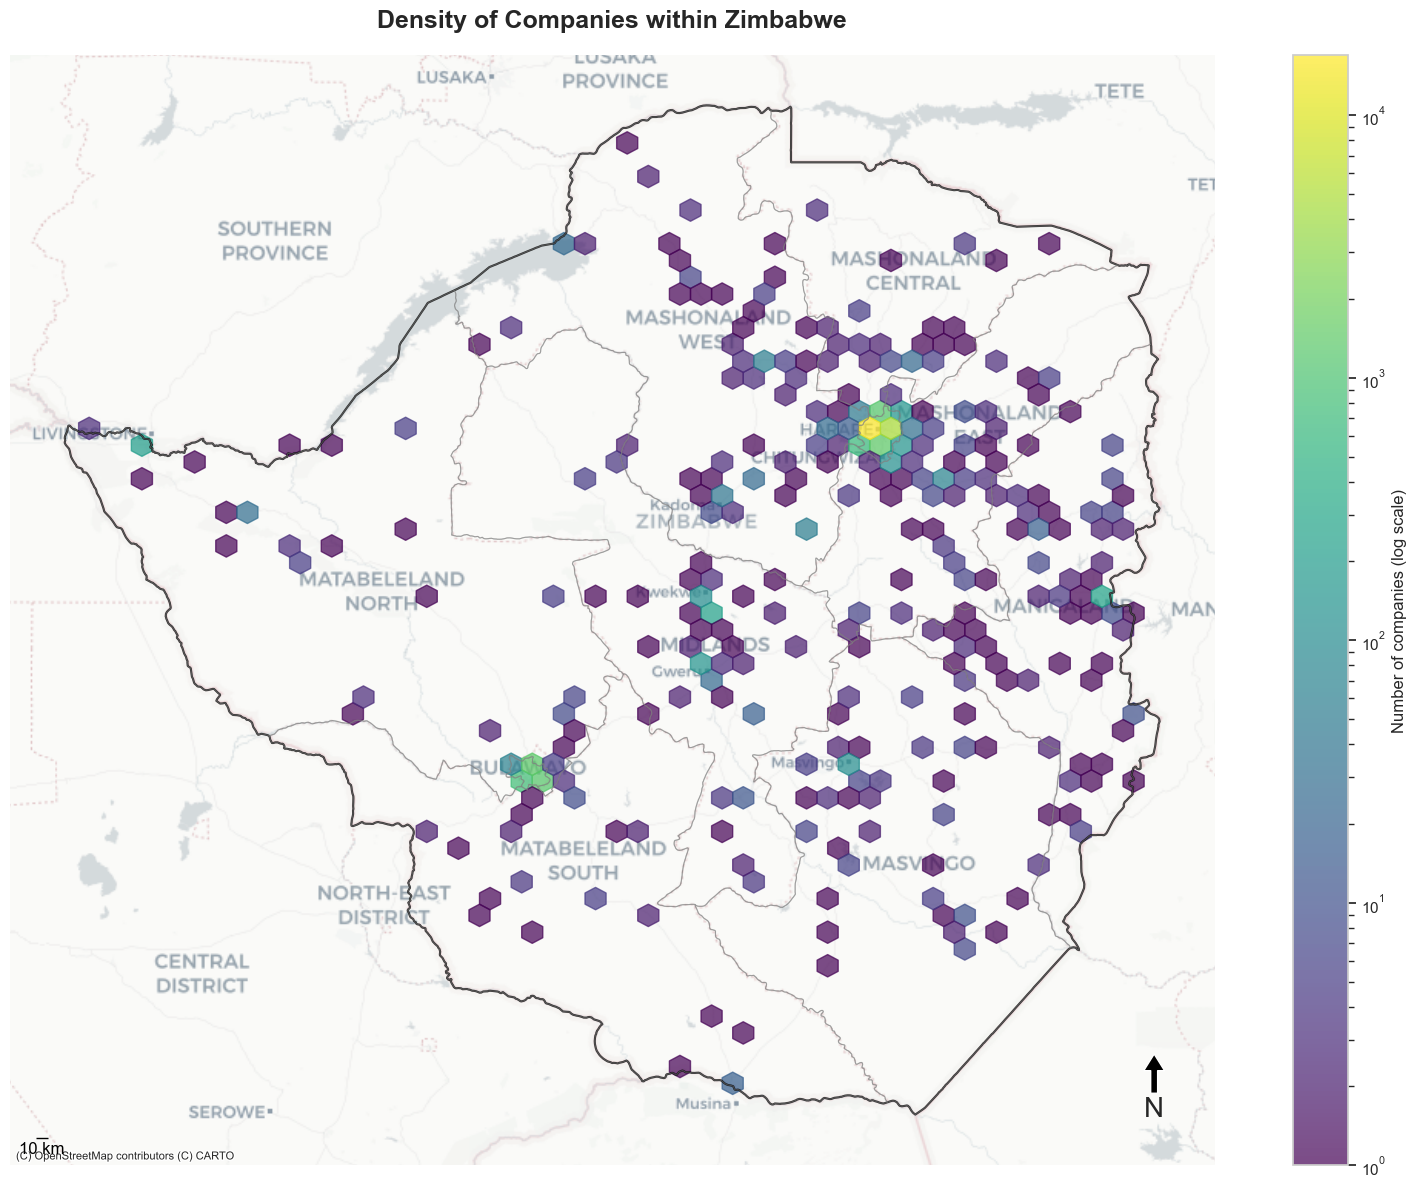


=== Statistical Analysis ===
Total companies: 31,374
Companies within Zimbabwe: 31,177 (99.4%)
Companies outside Zimbabwe: 197 (0.6%)


C:\Users\perkins.watambwa\AppData\Local\Temp\ipykernel_37768\1473138497.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Company Count', y='Province', data=province_counts,


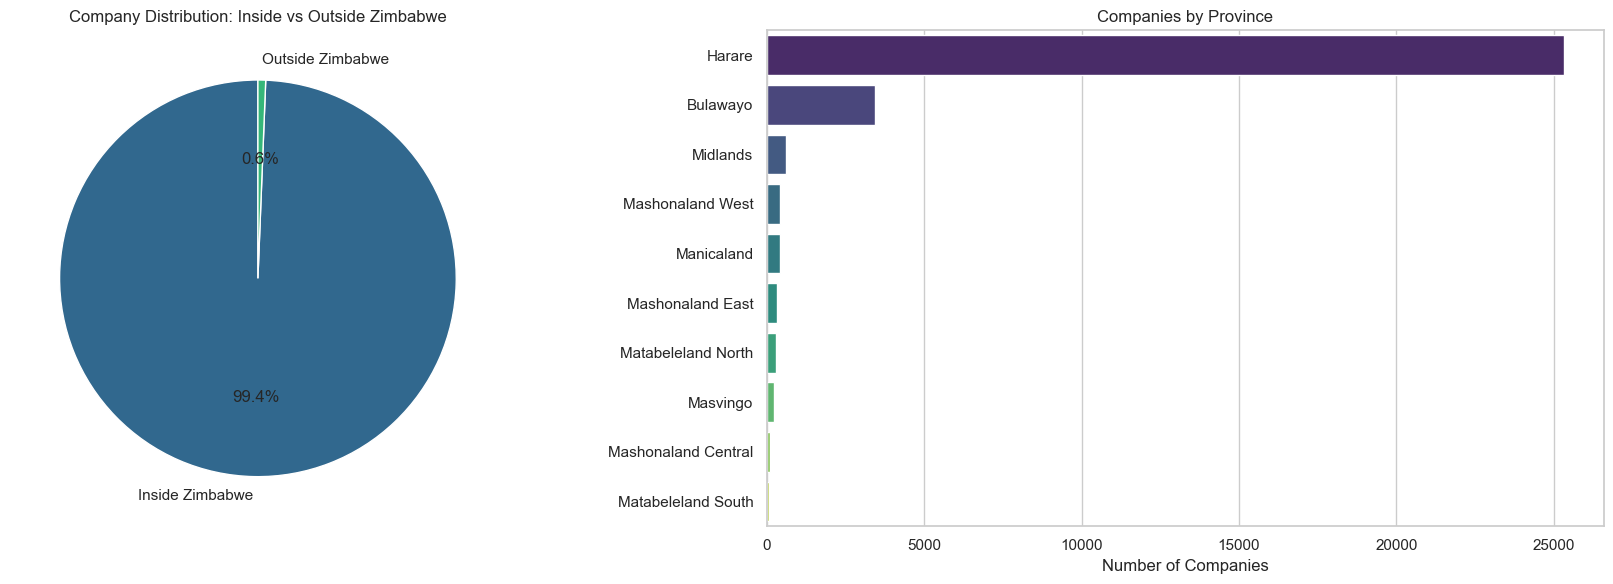

In [21]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Set style
plt.style.use('default')
sns.set_theme(style="whitegrid", palette="viridis")

def load_shapefiles(shapefile_dir='ZWE_adm'):
    """Load administrative boundary shapefiles with error handling."""
    print("Checking for shapefiles...")
    if not os.path.exists(shapefile_dir):
        raise FileNotFoundError(f"Directory '{shapefile_dir}' not found.")

    available_files = os.listdir(shapefile_dir)
    print(f"Available files: {available_files}")

    admin_levels = {
        'country': 'ZWE_adm0.shp',
        'province': 'ZWE_adm1.shp',
        'district': 'ZWE_adm2.shp',
        'ward': 'ZWE_adm3.shp'
    }

    shapefiles = {}
    for level, filename in admin_levels.items():
        filepath = os.path.join(shapefile_dir, filename)
        if filename in available_files:
            try:
                shapefiles[level] = gpd.read_file(filepath)
                print(f"Successfully loaded {level} data from {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {str(e)}")
        else:
            print(f"Warning: {filename} not found in {shapefile_dir}")

    return shapefiles

def prepare_company_data(companies_df, crs="EPSG:4326"):
    """Convert company data to GeoDataFrame and transform CRS."""
    print("Preparing company data...")
    geometry = [Point(xy) for xy in zip(companies_df.longitude, companies_df.latitude)]
    companies_gdf = gpd.GeoDataFrame(companies_df, geometry=geometry, crs=crs)
    return companies_gdf.to_crs(epsg=3857)  # Convert to Web Mercator

def filter_companies_in_country(companies_gdf, country_shape):
    """Filter companies to only those within the country boundaries."""
    if country_shape is None:
        print("No country boundary found. Cannot filter companies.")
        return companies_gdf

    # Ensure both are in the same CRS
    country_shape = country_shape.to_crs(companies_gdf.crs)

    # Create a single polygon from all country shapes
    country_boundary = country_shape.geometry.unary_union

    # Filter companies within the country boundary
    mask = companies_gdf.geometry.within(country_boundary)
    companies_in_country = companies_gdf[mask].copy()

    print(f"Found {len(companies_in_country)} companies within country boundaries.")
    return companies_in_country

def add_administrative_info(companies_gdf, shapefiles):
    """Add province, district, and ward information to company data."""
    print("Adding administrative information...")
    companies = companies_gdf.copy()

    def spatial_join(points, polygons, name_col, level_name):
        try:
            polygons = polygons.to_crs(points.crs)
            joined = gpd.sjoin(
                points,
                polygons[['geometry', name_col]],
                how='left',
                predicate='within'
            )
            return joined[name_col].rename(f"{level_name}_name")
        except Exception as e:
            print(f"Error in {level_name} spatial join: {str(e)}")
            return pd.Series(index=points.index, name=f"{level_name}_name")

    if 'province' in shapefiles:
        companies['province'] = spatial_join(companies, shapefiles['province'], 'NAME_1', 'province')
    if 'district' in shapefiles:
        companies['district'] = spatial_join(companies, shapefiles['district'], 'NAME_2', 'district')
    if 'ward' in shapefiles:
        companies['ward'] = spatial_join(companies, shapefiles['ward'], 'NAME_3', 'ward')

    return companies

def create_company_density_map(shapefiles, companies_gdf, title, output_file):
    """Create a density map of companies with administrative boundaries."""
    fig, ax = plt.subplots(figsize=(16, 12))

    # Plot country boundary if available
    if 'country' in shapefiles:
        country = shapefiles['country'].to_crs(epsg=3857)
        country.boundary.plot(ax=ax, linewidth=1.5, color='black', alpha=0.8)

    # Plot provinces
    if 'province' in shapefiles:
        provinces = shapefiles['province'].to_crs(epsg=3857)
        provinces.boundary.plot(ax=ax, linewidth=0.8, color='gray', alpha=0.5)

    # Plot companies
    if companies_gdf is not None and not companies_gdf.empty:
        x = companies_gdf.geometry.x
        y = companies_gdf.geometry.y
        hb = ax.hexbin(x, y, gridsize=50, cmap='viridis', alpha=0.7,
                      mincnt=1, bins='log')
        cb = fig.colorbar(hb, ax=ax, label='Number of companies (log scale)')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Add map elements
    ax.set_title(title, fontsize=18, pad=20, fontweight='bold')
    ax.axis('off')

    # Add scale bar
    scalebar = AnchoredSizeBar(
        ax.transData,
        10000,  # 10 km in meters
        '10 km',
        'lower left',
        pad=0.5,
        color='black',
        frameon=False,
        size_vertical=1
    )
    ax.add_artist(scalebar)

    # Add north arrow
    ax.annotate('N',
               xy=(0.95, 0.1),
               xytext=(0.95, 0.05),
               arrowprops=dict(facecolor='black', width=5, headwidth=15),
               ha='center',
               va='center',
               fontsize=20,
               xycoords=ax.transAxes)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Map saved as {output_file}")
    plt.show()

def save_company_data_with_admin(companies_df, output_file='companies_with_admin_info.csv'):
    """Save company data with administrative information to CSV."""
    if 'geometry' in companies_df.columns:
        companies_df = companies_df.drop(columns=['geometry'])

    companies_df.to_csv(output_file, index=False)
    print(f"Company data with administrative information saved to {output_file}")

def create_statistical_analysis(companies_all, companies_in_country, shapefiles):
    """Create statistical analysis and visualizations."""
    print("\n=== Statistical Analysis ===")

    total_companies = len(companies_all) if companies_all is not None else 0
    in_country = len(companies_in_country) if companies_in_country is not None else 0
    outside_country = total_companies - in_country

    print(f"Total companies: {total_companies:,}")
    if total_companies > 0:
        print(f"Companies within Zimbabwe: {in_country:,} ({in_country/total_companies:.1%})")
        print(f"Companies outside Zimbabwe: {outside_country:,} ({outside_country/total_companies:.1%})")

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Companies inside vs outside
    if total_companies > 0:
        counts = [in_country, outside_country]
        labels = ['Inside Zimbabwe', 'Outside Zimbabwe']
        axes[0].pie(counts, labels=labels, autopct='%1.1f%%',
                   startangle=90, colors=sns.color_palette('viridis', 2))
        axes[0].set_title('Company Distribution: Inside vs Outside Zimbabwe')

    # Plot 2: Companies by province
    if 'province' in shapefiles and companies_in_country is not None and not companies_in_country.empty:
        provinces = shapefiles['province'].to_crs(companies_in_country.crs)
        companies_with_province = gpd.sjoin(
            companies_in_country,
            provinces[['NAME_1', 'geometry']],
            how='left',
            predicate='within'
        )

        province_counts = companies_with_province['NAME_1'].value_counts().reset_index()
        province_counts.columns = ['Province', 'Company Count']

        if not province_counts.empty:
            sns.barplot(x='Company Count', y='Province', data=province_counts,
                       ax=axes[1], palette='viridis')
            axes[1].set_title('Companies by Province')
            axes[1].set_xlabel('Number of Companies')
            axes[1].set_ylabel('')

    plt.tight_layout()
    plt.savefig('company_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
try:
    # Load shapefiles
    shapefiles = load_shapefiles()

    # Prepare company data
    if 'companies' in globals() and not companies.empty:
        # Convert to GeoDataFrame and add administrative info
        companies_gdf = prepare_company_data(companies)

        # Save the enriched data to CSV
        companies_with_admin = add_administrative_info(companies_gdf, shapefiles)
        save_company_data_with_admin(companies_with_admin, 'companies_with_admin_info.csv')

        # Create map with all companies
        print("\nCreating map with all companies...")
        create_company_density_map(
            shapefiles,
            companies_gdf,
            'Density of All Companies',
            'all_companies_density_map.png'
        )

        # Filter companies to those within Zimbabwe
        if 'country' in shapefiles:
            companies_in_zwe = filter_companies_in_country(companies_gdf, shapefiles['country'])

            if not companies_in_zwe.empty:
                # Create map with only companies in Zimbabwe
                print("\nCreating map with companies in Zimbabwe...")
                create_company_density_map(
                    shapefiles,
                    companies_in_zwe,
                    'Density of Companies within Zimbabwe',
                    'zimbabwe_companies_density_map.png'
                )

                # Generate statistical analysis
                create_statistical_analysis(companies_gdf, companies_in_zwe, shapefiles)
            else:
                print("Warning: No companies found within Zimbabwe boundaries.")

                # Debug information
                print("\nDebug Info:")
                print(f"Total companies: {len(companies_gdf)}")
                print("Sample coordinates (first 5):")
                print(companies_gdf[['latitude', 'longitude']].head())

                # Check CRS
                print("\nCRS Info:")
                print(f"Companies CRS: {companies_gdf.crs}")
                print(f"Country shape CRS: {shapefiles['country'].crs}")

                # Check bounds
                print("\nBounds:")
                print(f"Companies bounds: {companies_gdf.total_bounds}")
                print(f"Country bounds: {shapefiles['country'].to_crs(companies_gdf.crs).total_bounds}")
        else:
            print("Warning: Could not filter companies by country - country boundary not found.")
    else:
        print("No company data found. Cannot create maps.")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("\nTroubleshooting tips:")
    print("1. Make sure the 'ZWE_adm' directory exists and contains the required shapefiles")
    print("2. Verify that your company data has 'latitude' and 'longitude' columns")
    print("3. Check that the coordinates are in the expected range (Zimbabwe is around 16-22°S, 25-34°E)")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Directory contents: {os.listdir()}")

### Adding the degree of Urbanization

In [29]:
## Loading the dataset
companies = pd.read_csv('companies_with_admin_info.csv')

In [30]:
# First, authenticate with your Google account
import ee
ee.Authenticate()

# After running the above, follow the instructions in the popup to authenticate
# Then run the initialization
ee.Initialize()


Successfully saved authorization token.


In [ ]:
# Install required packages
!pip install earthengine-api geemap rasterio geopandas matplotlib seaborn

# Import necessary libraries
import ee
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import contextily as ctx
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Initialize Earth Engine
try:
    ee.Initialize()
    print("Earth Engine initialized successfully!")
except Exception as e:
    print("Please authenticate Earth Engine first by running:")
    print("import ee")
    print("ee.Authenticate()")
    print("Then run this cell again")
    raise

# Configuration
BATCH_SIZE = 20  # Reduced for better stability
OUTPUT_CSV = 'companies_with_urbanization.csv'
PLOT_OUTPUT = 'urbanization_analysis.png'

def classify_urbanization(lat, lon):
    """Classify urbanization level using Global Urban Footprint (GUF)"""
    try:
        if pd.isna(lat) or pd.isna(lon):
            return None

        point = ee.Geometry.Point([lon, lat])

        # Load Global Urban Footprint (2012 data)
        guf = ee.Image("DLR/GUF/GUF_2012_global_v4_1")

        # Get built-up area in 1km radius
        stats = guf.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point.buffer(1000),  # 1km radius
            scale=30,  # 30m resolution
            maxPixels=1e9
        )

        # Get the built-up percentage
        built_up = ee.Number(stats.get('b1')).getInfo()

        # Classify based on built-up percentage
        if built_up is None:
            return 'Rural'
        elif built_up < 0.05:  # Less than 5% built-up
            return 'Rural'
        elif 0.05 <= built_up < 0.5:  # 5% to 50% built-up
            return 'Urban Cluster'
        else:  # More than 50% built-up
            return 'Urban Center'

    except Exception as e:
        print(f"Error processing point ({lat}, {lon}): {str(e)}")
        return None

def process_in_batches(df, batch_size=20):
    """Process points in batches to avoid timeouts"""
    tqdm.pandas()
    all_results = []

    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        batch = df.iloc[i:i+batch_size].copy()

        # Process each point in the batch
        batch['urbanization_level'] = batch.progress_apply(
            lambda row: classify_urbanization(row['latitude'], row['longitude']),
            axis=1
        )

        all_results.append(batch)
        time.sleep(1)  # Add delay between batches

    return pd.concat(all_results)

def create_visualizations(df, output_file):
    """Create visualizations of the results"""
    plt.figure(figsize=(18, 6))

    # Plot 1: Urbanization Distribution
    plt.subplot(1, 2, 1)
    urban_counts = df['urbanization_level'].value_counts()
    plt.pie(urban_counts,
            labels=urban_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('viridis', len(urban_counts)))
    plt.title('Distribution of Urbanization Levels')

    # Plot 2: Urbanization by Province (if data available)
    province_col = next((col for col in df.columns if 'province' in col.lower()), None)
    if province_col:
        plt.subplot(1, 2, 2)
        province_urban = pd.crosstab(df[province_col], df['urbanization_level'], normalize='index') * 100
        province_urban.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Urbanization Level by Province')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Percentage')
        plt.legend(title='Urbanization Level', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

def save_to_geojson(df, output_file):
    """Save results to GeoJSON"""
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )
    gdf.to_file(output_file, driver='GeoJSON')
    print(f"Results saved to {output_file}")

# Main execution
if __name__ == "__main__":
    try:
        # 1. Load data
        print("Loading company data...")
        companies = pd.read_csv('companies_with_admin_info.csv')

        # 2. Process data in batches
        print("\nClassifying urbanization levels...")
        companies_with_urban = process_in_batches(companies, batch_size=BATCH_SIZE)

        # 3. Save results
        companies_with_urban.to_csv(OUTPUT_CSV, index=False)
        print(f"\nResults saved to {OUTPUT_CSV}")

        # 4. Create visualizations
        print("\nGenerating visualizations...")
        create_visualizations(companies_with_urban, PLOT_OUTPUT)

        # 5. Save as GeoJSON (optional)
        save_to_geojson(companies_with_urban, 'companies_urbanization.geojson')

        # 6. Show summary
        print("\nUrbanization Level Summary:")
        print(companies_with_urban['urbanization_level'].value_counts(dropna=False))

        print("\nFirst few rows of results:")
        display(companies_with_urban.head())

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        # If there's an error, try to save any processed data
        if 'companies_with_urban' in locals():
            companies_with_urban.to_csv('partial_results.csv', index=False)
            print("Partial results saved to 'partial_results.csv'")

Defaulting to user installation because normal site-packages is not writeable
  Using cached earthengine_api-1.7.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached geemap-0.36.6-py3-none-any.whl.metadata (14 kB)
  Using cached google_cloud_storage-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached google_api_python_client-2.187.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached google_auth-2.43.0-py2.py3-none-any.whl.metadata (6.6 kB)
  Using cached google_auth_httplib2-0.2.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached httplib2-0.31.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached anywidget-0.9.21-py3-none-any.whl.metadata (8.9 kB)
  Using cached bqplot-0.12.45-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached eerepr-0.1.2-py3-none-any.whl.metadata (4.2 kB)
  Using cached geocoder-1.38.1-py2.py3-none-any.whl.metadata (14 kB)
  Using cached ipyevents-2.0.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached ipyfilechooser-0.6.0-py3-none-any.whl.metadata (6.4 kB)
  Using

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\perkins.watambwa\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\jedi\\third_party\\django-stubs\\django-stubs\\contrib\\contenttypes\\management\\commands\\remove_stale_contenttypes.pyi'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



Earth Engine initialized successfully!
Loading company data...

Classifying urbanization levels...


Processing batches:   0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-20.155478728457, 28.55078960442): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7925645, 31.0335281): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.783362200792, 31.024959969903): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8472949, 31.0724627): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.9729906, 32.6714688): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83998042857, 31.041362763225): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not ha

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.843302647059, 31.052840139472): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.82510717765, 31.019073614432): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.80984284238, 31.129358806924): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.111570952361, 28.606230787528): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.86453103993, 31.083783810773): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8187766, 31.0232735): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.764284152885, 31.034363023872): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8785732, 31.0877346): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.2834445, 30.7322668): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.6976159, 31.1076609): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.0901511, 30.8306064): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.166632493416, 28.585754573205): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have acces

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.807505851653, 31.130164679927): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.871244574972, 31.085583263118): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.888842537899, 30.96671810753): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.853749525973, 30.999949383879): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.850749927159, 31.050742603831): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.845477283864, 31.128484177513): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.857302525474, 31.019609411883): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.86938581709, 30.975430602164): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.829653022379, 31.050414780518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.155656857023, 28.574873604148): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.843687891039, 31.043734114418): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.860910798291, 31.04901361982): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does n

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.830251029998, 31.077816048426): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.753041124844, 31.084385228104): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.77984565837, 31.054406227288): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.732263222238, 31.036041029345): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.770306976543, 31.132546754771): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.80665989237, 31.078909096607): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.816430386173, 31.035715966306): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.779171703583, 31.028827792162): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.802760540922, 31.031628199628): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.82481373786, 31.056300774439): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.787678915908, 31.041025571079): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does n

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-20.1519036, 28.5849271): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.771367108717, 31.001575426482): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.759382124359, 31.003441844291): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.755971510488, 31.026950892968): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.753734651938, 31.090736079034): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.849390242662, 31.012175840855): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.491848598463, 29.802715843452): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.874822607045, 30.981695702447): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.814477511961, 31.035424363922): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.898748975393, 31.075147796689): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.797962894272, 31.045449903196): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.828242876513, 31.079295981015): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.1731032, 28.6578979): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8238479, 31.0213933): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.834470251826, 31.048935401223): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.827889472943, 31.057818213769): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.828242876513, 31.079295981015): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.745523196395, 31.096664302231): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.794500020126, 31.035034363684): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.848188008676, 31.04867337876): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83098895142, 31.039929841844): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.961038740602, 29.789084833526): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.762096655718, 31.001473282034): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does n

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.816430386173, 31.035715966306): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.834269927532, 31.040761281921): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.828166151207, 31.04262687117): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.016205471, 29.884276749): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83546261333, 31.042452107343): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.806006831305, 31.021979287798): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exi

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.830306288773, 31.095856245136): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.85311, 31.050123): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.867698980248, 31.049399919221): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.9729906, 32.6714688): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.874822607045, 30.981695702447): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not hav

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.838162332399, 31.036985256824): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.834355370922, 31.049389477604): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.860910798291, 31.04901361982): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823125191669, 31.042657270434): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.987354360323, 32.655300383387): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.776532386892, 31.027317895527): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.834209750775, 31.040765205283): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.814325272892, 31.029562712642): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.799554950932, 31.03295308609): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.811727098374, 31.034679907997): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.813467355532, 31.033471065035): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.803374540644, 31.044674451019): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.777815245954, 31.09123504728): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.805456880815, 31.076934860655): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.825740801485, 31.051909497209): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.826996115014, 31.057810131601): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.822410624257, 31.062371798845): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.11857269803, 28.61413792682): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.877067836625, 30.947365448202): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.886030098409, 31.007325975611): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist o

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8999216, 31.0428515): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8390912, 31.1860195): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.4531375, 29.8153637): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.452760780894, 29.818567278199): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.824466608901, 31.093590646869): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have acces

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.1882274, 31.546068): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.760258799915, 31.041542515115): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.835459191374, 31.02907114532): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.830066693077, 31.070109527532): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not ha

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.867694717629, 31.018049172572): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.794500020126, 31.035034363684): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.787427261367, 31.071884659035): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.753733774328, 30.985138061174): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7950349, 31.0239473): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-18.007369728549, 31.061443270819): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8616203, 31.0400068): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.829286471083, 31.041564367736): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.847178039663, 31.066275220774): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.773698444317, 31.128673345895): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.821659132634, 31.058862610891): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.814477511961, 31.035424363922): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7660385602, 31.07104288464): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.826996115014, 31.057810131601): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83098895142, 31.039929841844): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.836532978994, 31.065182190282): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.1519036, 28.5849271): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.825430608736, 31.118572570282): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.817350873973, 31.049430366881): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.787427261367, 31.071884659035): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.922287020236, 25.831879487201): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8238479, 31.0213933): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.824466608901, 31.093590646869): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.764704045051, 31.05407104436): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.826463706359, 31.050446231462): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.768746082563, 31.070423964909): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.837358068259, 31.002543767198): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.829709622379, 31.050173680518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.2240558, 28.5113168): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.4649931, 29.7591399): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83128223845, 31.051392391725): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.858483826669, 31.052596363672): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.872812023286, 31.095363208298): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.80489316935, 31.128953514607): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.814477511961, 31.035424363922): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.153087285977, 28.580176583935): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.991785638981, 31.048920074251): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.9055057, 30.9482266): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.820741682099, 31.047749810219): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.76794076129, 31.077612282): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.854825837384, 31.105252607701): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.827241966928, 31.04657641771): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.832594523368, 30.981630187825): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or c

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-20.166188299474, 28.581395518099): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.838556374627, 31.118169405252): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.884893091777, 31.016018601602): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.82481373786, 31.056300774439): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.832982437409, 31.039399676277): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.803374540644, 31.044674451019): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.838300699065, 31.107289443522): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.9338396, 29.8055392): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83019044661, 31.044634749766): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.857302525474, 31.019609411883): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.805456880815, 31.076934860655): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.826051401215, 31.011119830341): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.892059128773, 30.975005037111): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.786594921488, 31.099262083829): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.166955744614, 28.647576604627): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8238479, 31.0213933): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.181272740431, 28.558235248099): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.825740801485, 31.051909497209): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.866621513318, 30.965773608651): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.882299952525, 30.968342698123): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.877557315819, 30.981498402815): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.819222043148, 31.064700042424): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.826304650311, 31.050402132217): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7758732, 31.0641984): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.818508056385, 31.02688465674): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.749384860636, 31.022564265372): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8209629, 30.9513068): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-20.1519036, 28.5849271): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823759258209, 31.117339025567): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.4531375, 29.8153637): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-22.1997638, 29.9970029): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823499542645, 31.107816612525): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7705376, 31.0483382): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have acces

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-20.166188299474, 28.581395518099): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8448977, 31.056944): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.882356402685, 31.005515815675): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.9289767, 25.8367107): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.845134621278, 31.037204477163): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.738220021506, 31.105085913788): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.145841142569, 28.584700097461): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.854175064761, 31.078334823768): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.9289767, 25.8367107): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.790177761625, 31.033629919997): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.0137641, 31.0996045): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.816525925096, 31.04530551264): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.016205471, 29.884276749): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.826996115014, 31.057810131601): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7705376, 31.0483382): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.9338396, 29.8055392): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.82481373786, 31.056300774439): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does no

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.870342659904, 31.01664767508): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.816383451223, 31.045898814551): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.830502291087, 31.028916024815): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.1519036, 28.5849271): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not h

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.7680622, 31.1378917): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8814852, 30.9212746): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.1977735, 28.5955891): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.1519036, 28.5849271): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.829321867026, 30.953381770621): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.0177548, 29.7774501): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8209629, 30.9513068): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7835904, 31.1198967): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.712455934917, 31.143706849747): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.830306288773, 31.095856245136): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.864196979319, 31.101406853438): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.6709998, 28.875867): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not h

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.798775605793, 31.036149756138): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.82481373786, 31.056300774439): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.82481373786, 31.056300774439): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.764284152885, 31.034363023872): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.794128065327, 31.048752803754): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist o

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.830195752348, 31.044611301163): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.831160759845, 31.07280448264): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.838556374627, 31.118169405252): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.827889472943, 31.057818213769): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist 

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.79246546647, 31.045989296464): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.828166151207, 31.04262687117): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.828166151207, 31.04262687117): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.958344120044, 32.678039399668): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.829510567269, 31.047286881291): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.905544923099, 30.998933874431): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.831727349694, 31.078496687281): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.853402409237, 31.024600161253): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.915163392691, 30.941148325678): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.831303976029, 31.054838195943): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.831401856062, 31.050046447608): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.821372788302, 31.064653031493): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-18.9729906, 32.6714688): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.820531926937, 31.023375150742): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-19.016205471, 29.884276749): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.1663895, 28.5561483): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.739955787754, 31.096713533708): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.881643873673, 31.104666947402): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.819342766582, 31.047383265237): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or ca

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.890790533708, 31.018582688534): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.0617161, 30.8161941): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.828145031346, 31.047940807358): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.757240998446, 31.088486547157): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.838300699065, 31.107289443522): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.823207869506, 31.057733213446): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.877557315819, 30.981498402815): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.7830917, 31.0243488): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.840805436413, 31.107827030456): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.3595908, 30.1958155): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.880076611513, 30.976318965293): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-20.1519036, 28.5849271): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.853757128203, 31.004770117449): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.08428260984, 28.554558860439): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83546261333, 31.042452107343): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not ha

  0%|          | 0/20 [00:00<?, ?it/s]

Error processing point (-17.839424762727, 31.066919531427): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.1519036, 28.5849271): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-20.145841142569, 28.584700097461): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.83098895142, 31.039929841844): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.8276279, 31.0504518): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller does not have access).
Error processing point (-17.830924158942, 31.049055437723): Image.load: Image asset 'DLR/GUF/GUF_2012_global_v4_1' not found (does not exist or caller 